Notwenige Importe und Konfigurationsfile

In [1]:
import sys
import collections
sys.path.append("src")  # Falls noch nicht gesetzt

from audio_data import AudioDataSet
from feature_set import FeatureSet
from drone_classifier import DroneClassifier

config = {
    "sample_rate": 16000,
    "audio_length": 1, # in Sekunden
    "train_path": "d:/Dropbox/03 H2 Think/AuDroK mFund/Auswertungen/Datensätze/Drone vs. No Drone/TRAINING/",
    "val_path":   "d:/Dropbox/03 H2 Think/AuDroK mFund/Auswertungen/Datensätze/Drone vs. No Drone/VALIDATION/",
    "model_file": "models/classifier_001.keras",
    "feature_files": {
        "train_features": "models/train_features.pkl",
        "val_features": "models/val_features.pkl",
        "train_labels": "models/train_labels.pkl",
        "val_labels": "models/val_labels.pkl"
    }
}

Rohdaten fürs Training laden

Pre-Emphasis anwenden

chunken

In [2]:
# Laden des Audiodatensatzes für die Trainingsdaten
raw_data_train = AudioDataSet.from_path(
    path=config["train_path"],
    sample_rate=config["sample_rate"]
)

# Apply Pre-Emphasis auf die Trainingsrohdaten
for audio in raw_data_train.audio:
    audio.apply_pre_emphasis()

# Chunken der Trainingsrohdaten
chunk_length = config["sample_rate"] * config["audio_length"]
chunked_data_train = raw_data_train.chunk_all(chunk_length)
print(f"{len(chunked_data_train.audio)} Chunks")

from collections import Counter
import random, copy
from audio_data import AudioDataSet

# Klassen zählen
print("Train class dist:", Counter([a.label for a in chunked_data_train.audio]))

# Split nach Label
dr = [a for a in chunked_data_train.audio if a.label == "drone"]
nd = [a for a in chunked_data_train.audio if a.label == "no drone"]

# Anzahl angleichen (Oversampling von no drone)
needed = max(0, len(dr) - len(nd))
nd_extra = [copy.deepcopy(random.choice(nd)) for _ in range(needed)]

# Augmentieren, damit es nicht 1:1 Duplikate sind
from augmentations import apply_ground_reflection_to_dataset
ranges = {"src_x": (-10, 10), "src_y": (-10, 10), "src_z": (1, 5),
          "mic_z": (1, 2), "attenuation": (0.05, 0.95)}
nd_extra_ds = apply_ground_reflection_to_dataset(AudioDataSet(nd_extra),
                                                 sample_rate=config["sample_rate"],
                                                 ranges=ranges)

# Neues balanciertes Trainingsset
balanced_train_data = AudioDataSet(dr + nd + nd_extra_ds.audio)

# Zwischenspeichern der Trainingsdaten zur Vereinfachung des Debuggings
import pickle

with open("chunked_data_train.pkl", "wb") as f:
    pickle.dump(chunked_data_train, f)

import collections
print(collections.Counter([a.label for a in chunked_data_train.audio]))


Processing audio files (3266 files to process):
[#######################################.] 99.48%
39171 Chunks
Train class dist: Counter({'drone': 35028, 'no drone': 4143})
Counter({'drone': 35028, 'no drone': 4143})


Laden der zwischengespeicherten Gechunkten und vorverarbeiteten Trainingsdaten

In [3]:
## Laden
#import pickle
#
#with open("chunked_data_train.pkl", "rb") as f:
#    chunked_data_train = pickle.load(f)

Rohdaten für die Validierung laden

Pre-Emphasis anwenden

chunken

Zwischenspeichern

In [4]:
raw_data_val = AudioDataSet.from_path(
    path=config["val_path"],
    sample_rate=config["sample_rate"]
)

# Pre-Emphasis
for audio in raw_data_val.audio:
    audio.apply_pre_emphasis()

# Chunken
chunk_length = config["sample_rate"] * config["audio_length"]
chunked_data_val = raw_data_val.chunk_all(chunk_length)
print(f"{len(chunked_data_val.audio)} Chunks")

# Zwischenspeichern der vorverarbeiteten Validierungsdaten
import pickle

with open("chunked_data_val.pkl", "wb") as f:
    pickle.dump(chunked_data_val, f)

Processing audio files (277 files to process):
[####################################....] 92.42%
34211 Chunks


In [5]:
from collections import Counter
print("Train:", Counter([a.label for a in chunked_data_train.audio]))
print("Val  :", Counter([a.label for a in chunked_data_val.audio]))


Train: Counter({'drone': 35028, 'no drone': 4143})
Val  : Counter({'drone': 28575, 'no drone': 5636})


Laden der zwischengespeicherten vorverarbeiteten Validierungsdaten

In [6]:
## Laden
#import pickle
#
#with open("chunked_data_val.pkl", "rb") as f:
#    chunked_data_val = pickle.load(f)

Augmentieren der TRainingsdaten durch das Hinzufügen von Noise

In [7]:
# --- Noise-Augmentierung im Dataset-Stil (ohne X_/y_-Vorgriffe) ---

from augmentations import apply_noise_augmentation
from audio_data import AudioDataSet

# 1) Noise-Dataset aus echten No-Drone-Validierungs-Chunks bauen
noise_from_val = [a for a in chunked_data_val.audio if a.label.lower() in ("no drone", "no_drone", "no-drone")]
noise_ds = AudioDataSet(noise_from_val)

# 2) Drohnen im Trainingsset separieren (balanced_train_data existiert bei dir bereits)
drone_train = [a for a in balanced_train_data.audio if a.label.lower() == "drone"]
no_drone_train = [a for a in balanced_train_data.audio if a.label.lower() != "drone"]

drone_train_ds = AudioDataSet(drone_train)
no_drone_train_ds = AudioDataSet(no_drone_train)

# 3) Drohnen mit Val-Noise mischen (SNR-Logik steckt in apply_noise_augmentation)
#    max_snr_db belassen oder moderat setzen. Höher = weniger Noise, niedriger/negativ = mehr Noise.
aug_drone_ds = apply_noise_augmentation(
    drone_dataset=drone_train_ds,
    noise_dataset=no_drone_train_ds if len(no_drone_train) > 0 else noise_ds,  # Fallback
    sample_rate=config["sample_rate"],
    # max_snr_db=-6  # optional anpassen, falls du härtere Bedingungen willst
)

# 4) Neues Trainings-Dataset zusammensetzen: (augmentierte Drohnen) + (No-Drone unverändert)
augmented_train_data = AudioDataSet(aug_drone_ds.audio + no_drone_train_ds.audio)

# 5) Optional: dezentes Echo oben drauf (deine bestehende Funktion arbeitet ebenfalls auf AudioDataSet)
from augmentations import apply_ground_reflection_to_dataset
ranges = {"src_x": (-10, 10), "src_y": (-10, 10), "src_z": (1, 5),
          "mic_z": (1, 2), "attenuation": (0.05, 0.95)}
augmented_train_data = apply_ground_reflection_to_dataset(
    augmented_train_data, sample_rate=config["sample_rate"], ranges=ranges
)


Adding Background Noise: 100%|████████████████████████████████████████████████████████████████████| 35028/35028 [00:09<00:00, 3886.10it/s]


Feature Extraction

In [8]:
# Feature-Extraktion (liefert X_*, y_*)
train_features = FeatureSet(augmented_train_data, sample_rate=config["sample_rate"])
X_train, y_train = train_features.extract()

val_features = FeatureSet(chunked_data_val, sample_rate=config["sample_rate"])
X_val, y_val = val_features.extract()

Processing features (70056 files to process):
[########################################] 100.00%
Processing features (34211 files to process):
[########################################] 100.00%


Zwischenspeichern der Features zur Vereinfachung des Debuggings (funktioniert derzeit nicht korrekt, beim Laden ändert sich das Format)

In [9]:
## Speichern
#import pickle
#
#with open("features.pkl", "wb") as f:
#    pickle.dump({
#        "X_train": X_train,
#        "y_train": y_train,
#        "X_val": X_val,
#        "y_val": y_val
#    }, f)

In [10]:
## Laden
#import pickle
#
#with open("features.pkl", "rb") as f:
#    data = pickle.load(f)

#X_train = data["X_train"]
#y_train = data["y_train"]
#X_val = data["X_val"]
#y_val = data["y_val"]

Modelltraining & Evaluation

Label mapping (fixed): {'no drone': 0, 'drone': 1}
Encoded Labels - Train: [0 1]
Encoded Labels - Validation: [0 1]
Class counts: {0: 35028, 1: 35028}
Class weights (balanced): {0: 1.0, 1: 1.0}
Epoch 1/30
1095/1095 - 747s - 682ms/step - auc: 0.9864 - auprc: 0.9876 - loss: 0.2093 - precision: 0.9478 - recall: 0.9415 - val_auc: 0.6674 - val_auprc: 0.9110 - val_loss: 1.1633 - val_precision: 0.9133 - val_recall: 0.4854 - learning_rate: 5.0000e-04
Epoch 2/30
1095/1095 - 634s - 579ms/step - auc: 0.9951 - auprc: 0.9956 - loss: 0.1529 - precision: 0.9740 - recall: 0.9663 - val_auc: 0.7617 - val_auprc: 0.9319 - val_loss: 0.8722 - val_precision: 0.9176 - val_recall: 0.6426 - learning_rate: 5.0000e-04
Epoch 3/30
1095/1095 - 629s - 575ms/step - auc: 0.9971 - auprc: 0.9974 - loss: 0.1328 - precision: 0.9796 - recall: 0.9751 - val_auc: 0.7671 - val_auprc: 0.9419 - val_loss: 1.2606 - val_precision: 0.9429 - val_recall: 0.5571 - learning_rate: 5.0000e-04
Epoch 4/30
1095/1095 - 625s - 570ms/step - auc:

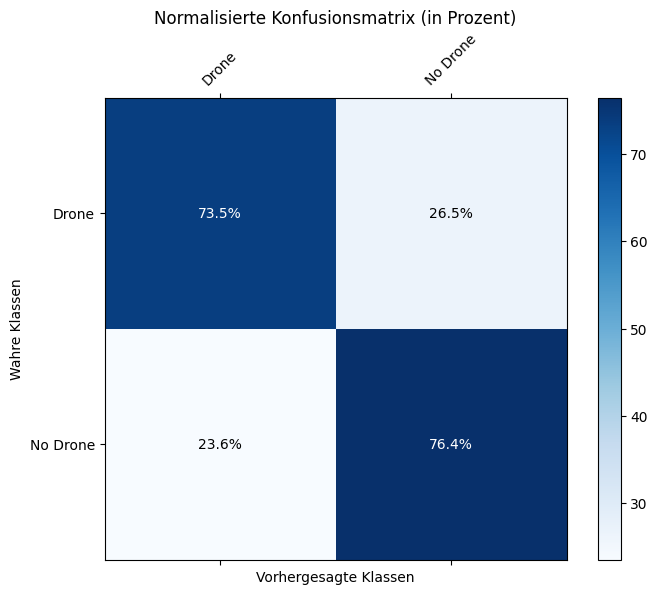

In [11]:
model = DroneClassifier(model_path="models/classifier_010.keras", trainable_layers=5)
model.train(X_train, y_train, X_val, y_val)
accuracy = model.evaluate(X_val, y_val)

print(f"Validierungsgenauigkeit: {accuracy:.2%}")